Notebook to build the model for predictiion

In [35]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import pydantic
import seaborn as sns
import joblib

In [49]:
data = pd.read_csv("Medicaldataset.csv")

In [37]:
data.head(10)

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative
5,58,0,61,112,58,87.0,1.83,0.004,negative
6,32,0,40,179,68,102.0,0.71,0.003,negative
7,63,1,60,214,82,87.0,300.00,2.370,positive
8,44,0,60,154,81,135.0,2.35,0.004,negative
9,67,1,61,160,95,100.0,2.84,0.011,negative


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [40]:
data.describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


## Feature Engineering
Replace positive to 1 and negative to 0 for sklearn.

In [62]:
y = data['Result'].apply(lambda x: 1 if x == 'positive' else 0)
X = data.drop('Result', axis=1)

In [63]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: Result, dtype: int64

In [64]:
print(f"   Features: {X.shape[1]} columns")
print(f"   Samples: {X.shape[0]} rows")
print(f"   Positive cases: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")
print(f"   Negative cases: {(1-y).sum()} ({(1-y).sum()/len(y)*100:.1f}%)")

   Features: 8 columns
   Samples: 1319 rows
   Positive cases: 810 (61.4%)
   Negative cases: 509 (38.6%)


Clean outliers

In [65]:
X_clean = X.copy()
X_clean.loc[X_clean['Heart rate'] > 200, 'Heart rate'] = X_clean['Heart rate'].median()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
print(f"   Training set: {len(X_train)} samples")
print(f"   Test set: {len(X_test)} samples")

   Training set: 1055 samples
   Test set: 264 samples


Training the Random Forest Classifier

In [68]:
model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Prevent overfitting
    min_samples_split=5,     # Minimum samples to split
    min_samples_leaf=2,      # Minimum samples in leaf
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

Evaluating the model

In [71]:
# Training accuracy
from sklearn.model_selection import cross_val_score


train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print(f"   Training Accuracy: {train_accuracy*100:.2f}%")

# Test accuracy
test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")

# Cross-validation
cv_scores = cross_val_score(model, X_clean, y, cv=5)
print(f"   Cross-Validation Accuracy: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)")

# Detailed metrics
print("\n Classification Report:")
print(classification_report(y_test, test_pred, 
                           target_names=['Negative', 'Positive']))

# Confusion Matrix
print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, test_pred)
print(cm)
print(f"   True Negatives: {cm[0,0]}")
print(f"   False Positives: {cm[0,1]}")
print(f"   False Negatives: {cm[1,0]}")
print(f"   True Positives: {cm[1,1]}")

# Feature Importance
print("\n Feature Importance:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.iterrows():
    print(f"   {row['feature']}: {row['importance']*100:.2f}%")

# Save model
print("\n Saving model...")
joblib.dump(model, 'heart_attack_model.pkl')
print(" Model saved as 'heart_attack_model.pkl'")

# Save feature names for prediction script
joblib.dump(feature_importance['feature'], 'feature_names.pkl')
print("Feature names saved")

   Training Accuracy: 99.53%
   Test Accuracy: 97.73%
   Cross-Validation Accuracy: 98.56% (+/- 1.00%)

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97       101
    Positive       0.98      0.98      0.98       163

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264


 Confusion Matrix:
[[ 98   3]
 [  3 160]]
   True Negatives: 98
   False Positives: 3
   False Negatives: 3
   True Positives: 160

 Feature Importance:
   Troponin: 58.66%
   CK-MB: 25.78%
   Age: 5.56%
   Blood sugar: 2.83%
   Systolic blood pressure: 2.35%
   Diastolic blood pressure: 2.06%
   Heart rate: 1.63%
   Gender: 1.13%

 Saving model...
 Model saved as 'heart_attack_model.pkl'
Feature names saved


In [72]:
# setting the plt style for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

Visualizing

✅ Feature importance plot saved as 'feature_importance.png'


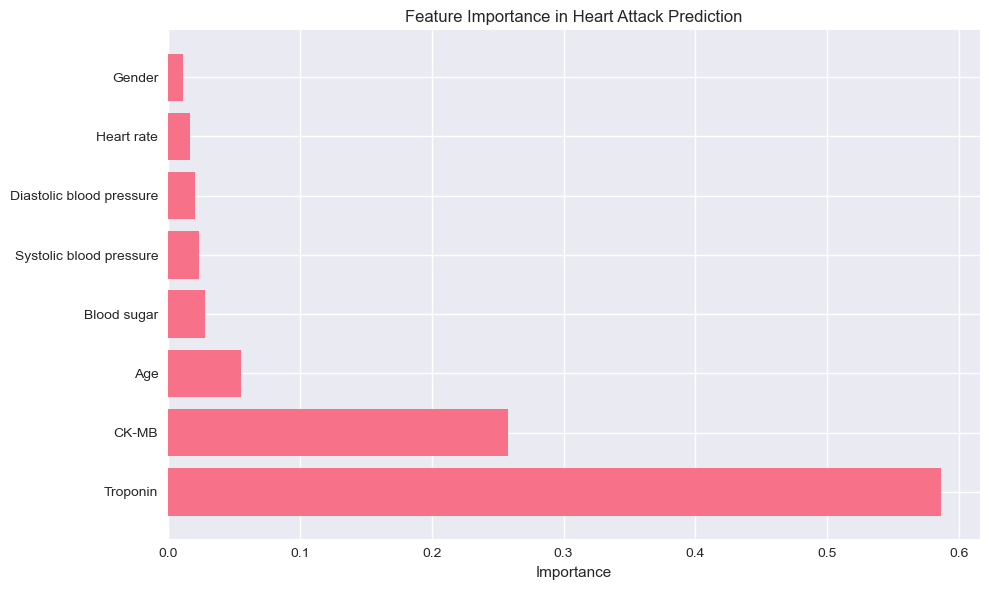

In [73]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Heart Attack Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("✅ Feature importance plot saved as 'feature_importance.png'")

In [78]:
# Summary
print(" MODEL TRAINING COMPLETE:\n")
print(f" Final Test Accuracy: {test_accuracy*100:.2f}%")
print(f" Algorithm: Random Forest with {model.n_estimators} trees")
print(f" Model file: heart_attack_model.pkl")
print(f" Most important feature: {feature_importance.iloc[0]['feature']}")

 MODEL TRAINING COMPLETE:

 Final Test Accuracy: 97.73%
 Algorithm: Random Forest with 100 trees
 Model file: heart_attack_model.pkl
 Most important feature: Troponin
